In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(1)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 384

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='deit_base_patch16_224',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('deit_base_patch16_224',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.0002290867705596611)

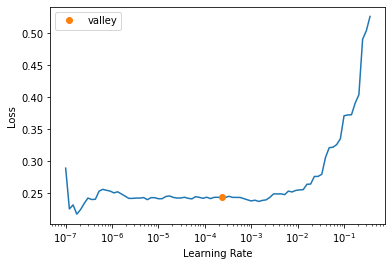

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.185321,0.190997,0.500000,0.000000,0.000000,0.000000,0.629352,02:46


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with f1_score value: 0.0.


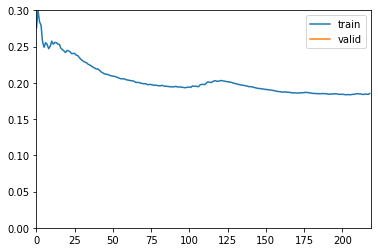

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.165343,0.161356,0.624359,0.622785,0.630769,0.626752,0.688616,01:36
1,0.163263,0.222716,0.519231,0.509987,0.982051,0.671341,0.702571,01:38
2,0.163249,0.158923,0.642308,0.614907,0.761538,0.680412,0.700447,01:39
3,0.159200,0.166530,0.607692,0.579245,0.787179,0.667391,0.686637,01:38
4,0.158432,0.180713,0.623077,0.582474,0.869231,0.697531,0.702107,01:39
5,0.158548,0.169863,0.603846,0.675325,0.400000,0.502415,0.683087,01:38
6,0.159758,0.160104,0.639744,0.605825,0.800000,0.689503,0.708632,01:38
7,0.163185,0.178228,0.528205,0.514589,0.994872,0.678322,0.722005,01:39


Better model found at epoch 0 with f1_score value: 0.6267515923566879.


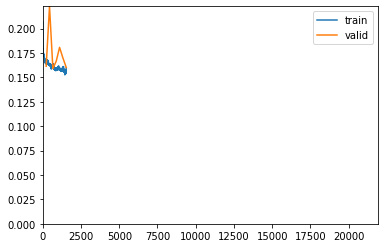

Better model found at epoch 1 with f1_score value: 0.6713409290096407.
Better model found at epoch 2 with f1_score value: 0.6804123711340208.
Better model found at epoch 4 with f1_score value: 0.6975308641975309.
No improvement since epoch 2: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=32,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.7131013806706115.


(#6) [0.17860396206378937,0.626153826713562,0.5872340425531914,0.8492307692307692,0.6943396226415094,0.7131013806706115]